## E- Coverage tests

Authors: Noemi Anau Montel, James Alvey, Christoph Weniger

Last update: 2 August 2023

**Purpose**: Testing posteriors and inference results.

**Key take-away messages**: How can we generate pp and zz plot with swyft?

### Code

In [ ]:
import numpy as np
import pylab as plt
import torch
import swyft

We again consider the same linear regression problem as above...

In [ ]:
N = 10_000  # Number of samples
Nbins = 100
z = np.random.rand(N, 3)*2 - 1
y = np.linspace(-1, 1, Nbins)
m = np.ones_like(y)*z[:,:1] + y*z[:,1:2] + y**2*z[:,2:]
x = m + np.random.randn(N, Nbins)*0.2 #+ np.random.poisson(lam = 3/Nbins, size = (N, Nbins))*5

# We keep the first sample as observation, and use the rest for training
samples = swyft.Samples(x = x, z = z)
obs = swyft.Sample(samples[0])

...as well as an inference network with linear data summaries, ...

In [ ]:
class Network(swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        self.summarizer = torch.nn.Linear(Nbins, 3)
        self.logratios = swyft.LogRatioEstimator_1dim(num_features = 1, num_params = 3, varnames = 'z')

    def forward(self, A, B):
        s = self.summarizer(A['x'])
        s = s.unsqueeze(-1)
        return self.logratios(s, B['z'])

...and train our inference network as usual.

In [ ]:
trainer = swyft.SwyftTrainer(accelerator = 'gpu', devices=1, max_epochs = 3, precision = 64)
dm = swyft.SwyftDataModule(samples[1:-500], fractions = [0.8, 0.2, 0.0])
network = Network()
trainer.fit(network, dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type                   | Params
------------------------------------------------------
0 | summarizer | Linear                 | 303   
1 | logratios  | LogRatioEstimator_1dim | 52.2 K
------------------------------------------------------
52.5 K    Trainable params
0         Non-trainable params
52.5 K    Total params
0.420     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


Like above, let's look at the posteriors for a specific mock observation `obs`.

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 238it [00:00, ?it/s]

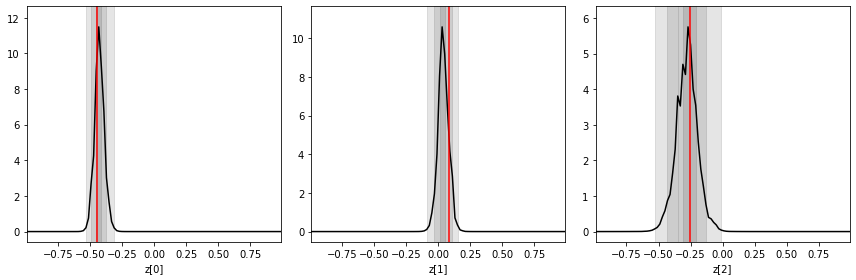

In [ ]:
prior_samples = swyft.Samples(z = np.random.rand(10_000, 3)*2-1)
predictions = trainer.infer(network, obs, prior_samples)

truth = {k: v for k, v in zip(["z[%i]"%i for i in range(3)], obs['z'])}
swyft.plot_posterior(predictions, ["z[%i]"%i for i in range(3)], truth=truth)

How do we know that these posteriors are "correct"?  Let us now consider Bayesian coverage.  To this end, we use the last 500 samples and estimate the Bayesian coverage (the fraction of samples where the $1-\alpha$ credible region contains the true value -- which should be $1-\alpha$).

In [ ]:
coverage_samples = trainer.test_coverage(network, samples[-500:], prior_samples)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 238it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 238it [00:00, ?it/s]

The coverage test restults can be visualized using `swyft.plot_pp`, which generates the standard pp-plot commonly seen in the literature. The disadvantage of this plot is that it squashes the particularly interesting high-credibility regions together.

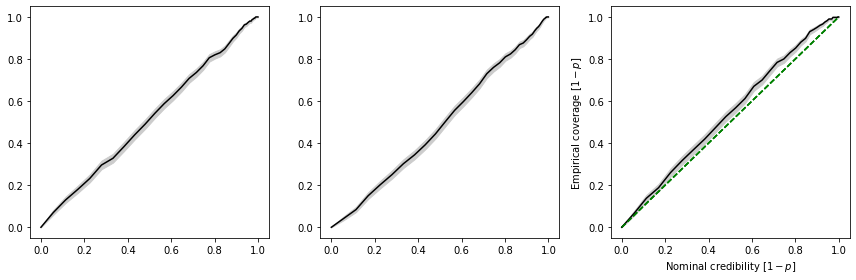

In [ ]:
fix, axes = plt.subplots(1, 3, figsize = (12, 4))
for i in range(3):
    swyft.plot_pp(coverage_samples, "z[%i]"%i, ax = axes[i])
plt.tight_layout()

Instead, in Swyft we use something we decided to call zz-plots, `swyft.plot_zz`, which emphasises high credibility regions and visualizes the uncertainties of the coverage test which are associated with a finite sample size (in this example just 500).

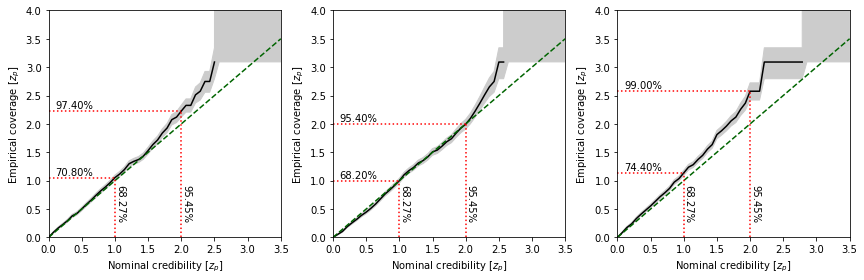

In [ ]:
fix, axes = plt.subplots(1, 3, figsize = (12, 4))
for i in range(3):
    swyft.plot_zz(coverage_samples, "z[%i]"%i, ax = axes[i])
plt.tight_layout()

### Exercises

1. Check how coverage changes when reducing or increasing the number of epochs during training.  An overtrained network will have overconfident coverage.

In [ ]:
# Your results here